In [1]:
from math import pi

from matplotlib import pyplot as plt
from numpy.fft import fftshift

from ppdenoise.ppdenoise import _gaussian_angular_filter, _filter_grids, _grid_angles, _gaussian_angular_filter_3d, \
    _filter_grids_3d, _grid_angles_3d

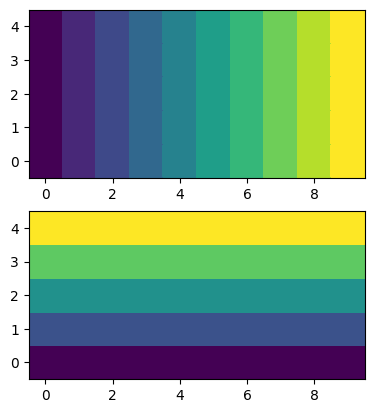

In [2]:
import numpy as np

x, y = np.meshgrid(list(range(10)), list(range(5)), indexing='ij')

fig, axes = plt.subplots(2)
axes[0].pcolor(x, y, x)
axes[1].pcolor(x, y, y)
for ax in axes:
    ax.set_aspect('equal')

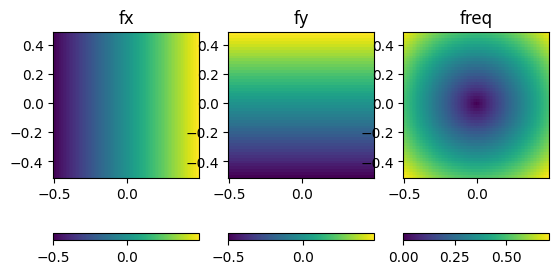

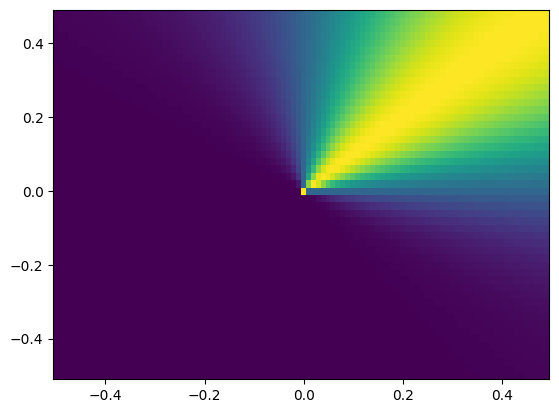

In [3]:
rows, cols = 50, 100
angle_rad = 45 * pi / 180
thetaSigma = pi / 6

freq, fx, fy = _filter_grids(rows, cols)
fx_s = fftshift(fx)
fy_s = fftshift(fy)
freq_s = fftshift(freq)

fig, axes = plt.subplots(1, 3)
cax = axes[0].pcolor(fx_s, fy_s, fx_s)
axes[0].set_title('fx')
fig.colorbar(cax, orientation='horizontal')
cax = axes[1].pcolor(fx_s, fy_s, fy_s)
axes[1].set_title('fy')
fig.colorbar(cax, orientation='horizontal')
cax = axes[2].pcolor(fx_s, fy_s, freq_s)
axes[2].set_title('freq')
fig.colorbar(cax, orientation='horizontal')
for ax in axes:
    ax.set_aspect('equal')

sintheta, costheta = _grid_angles(freq, fx, fy)
sintheta_s = fftshift(sintheta)
costheta_s = fftshift(costheta)
angle_filter = _gaussian_angular_filter(angle_rad, thetaSigma, sintheta, costheta)

fig, ax = plt.subplots()
ax.pcolor(fx_s, fy_s, fftshift(angle_filter))

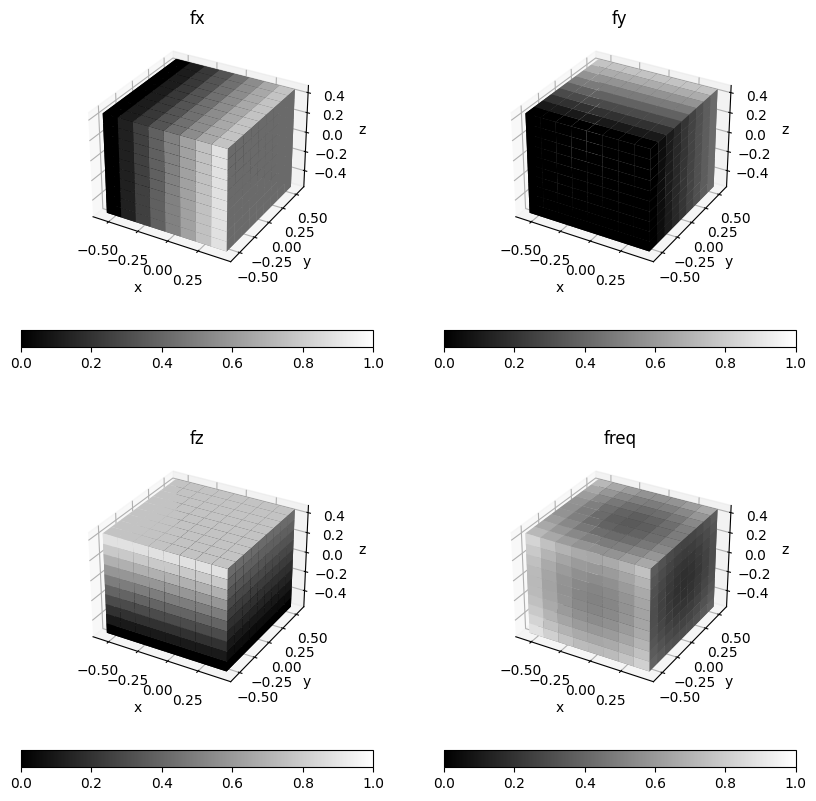

In [4]:
from ppdenoise.ppdenoise import _spaced_frequencies
import numpy as np
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D


def to_edges(centres: list[float]) -> list[float]:
    diffs = np.diff(centres)
    inner_edges = centres[:-1] + diffs / 2
    border_pad = np.median(diffs) / 2
    return [centres[0] - border_pad, *inner_edges, centres[-1] + border_pad]


nx, ny, nz = 8, 9, 10
fx_c, fy_c, fz_c = np.meshgrid(
    to_edges(_spaced_frequencies(nx)),
    to_edges(_spaced_frequencies(ny)),
    to_edges(_spaced_frequencies(nz)),
    indexing='ij'
)
freq, fx, fy, fz = _filter_grids_3d(nx, ny, nz)

# Test axes
fig: plt.Figure
axes: np.ndarray[Axes3D]
fig, axes = plt.subplots(2, 2, subplot_kw={"projection": "3d"})
fig.set_size_inches(10, 10)

for ax, vox, title in zip(axes.flatten(),
                          (fx, fy, fz, freq),
                          ('fx', 'fy', 'fz', 'freq')):
    vox = fftshift(vox)
    m = mpl.cm.ScalarMappable(cmap=plt.cm.gray)
    cax = ax.voxels(fx_c, fy_c, fz_c, np.ones_like(vox),
                    facecolors=mpl.colormaps['gray']((vox - vox.min()) / (vox.max() - vox.min())), alpha=1.0)
    ax.set_title(title)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    m = mpl.cm.ScalarMappable(cmap=plt.cm.gray)
    fig.colorbar(m, ax=ax, orientation='horizontal')

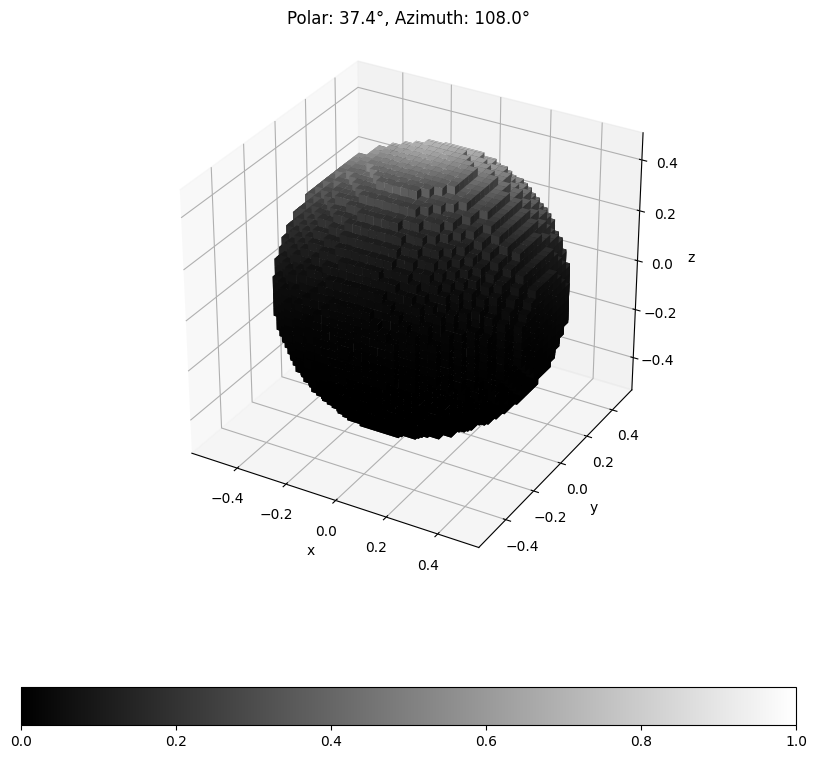

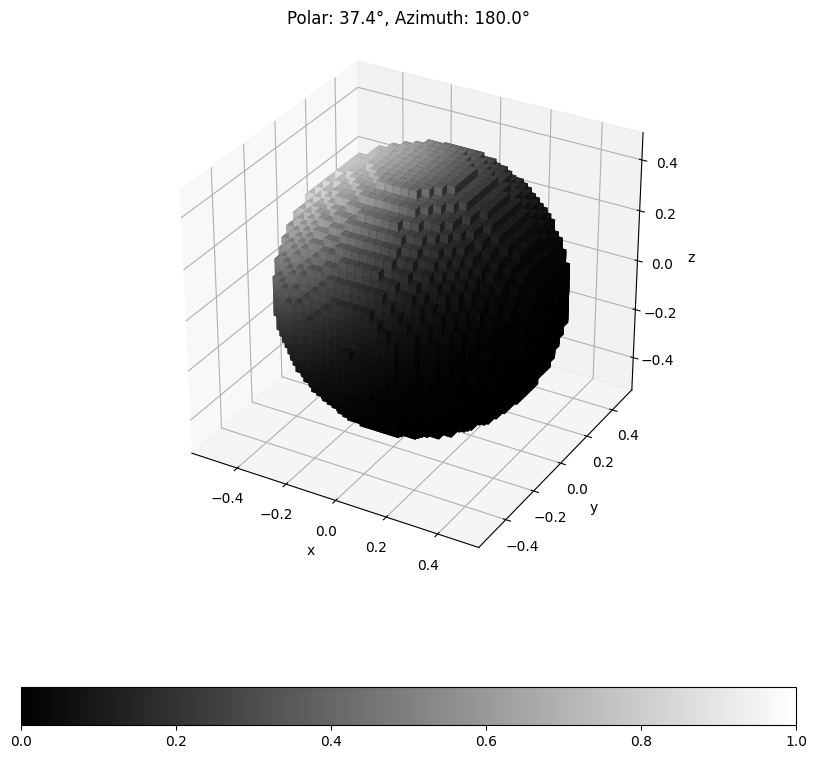

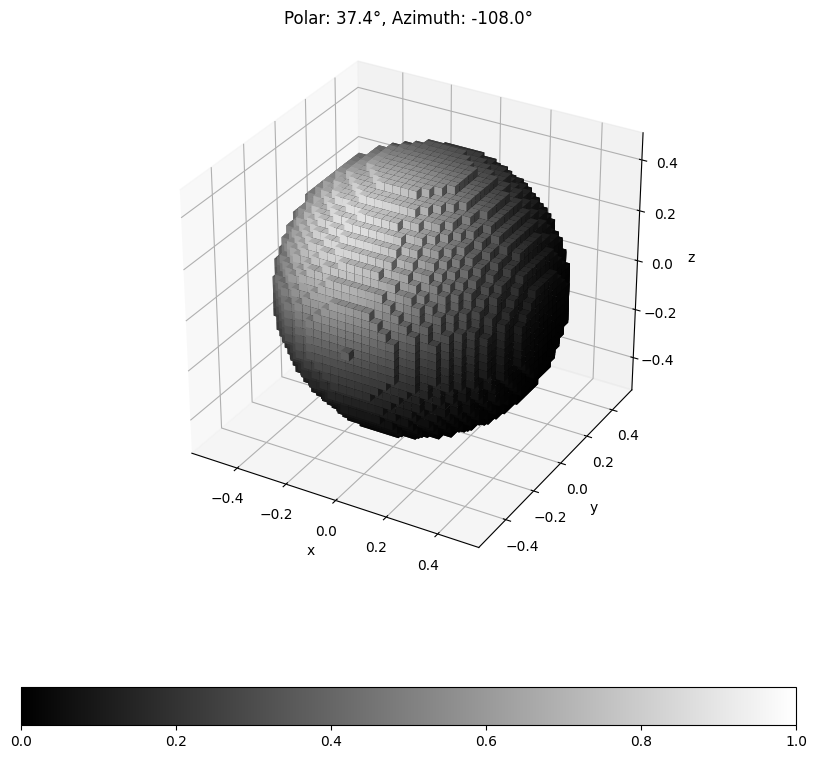

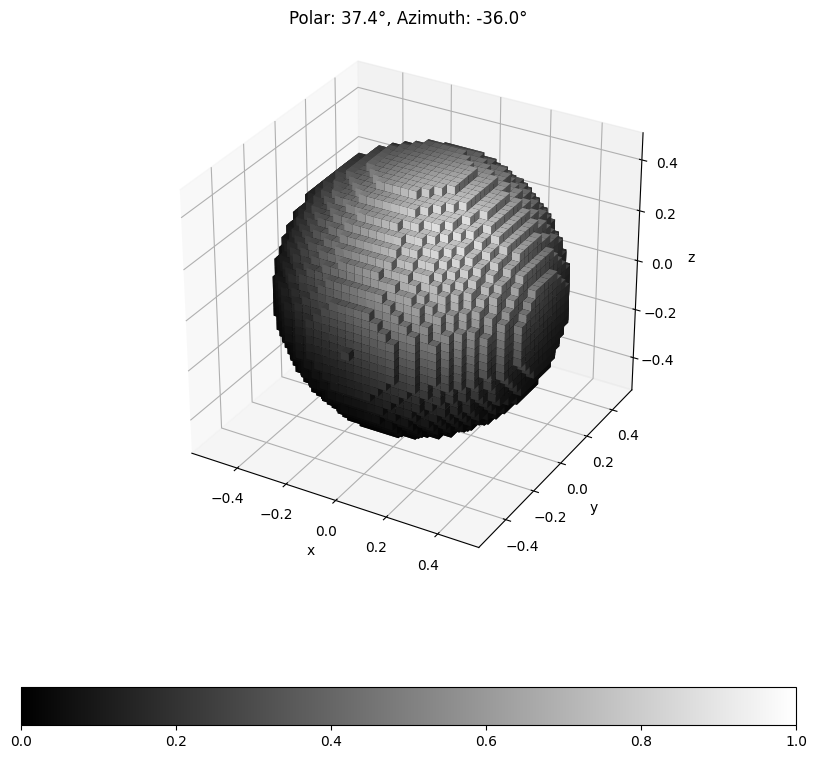

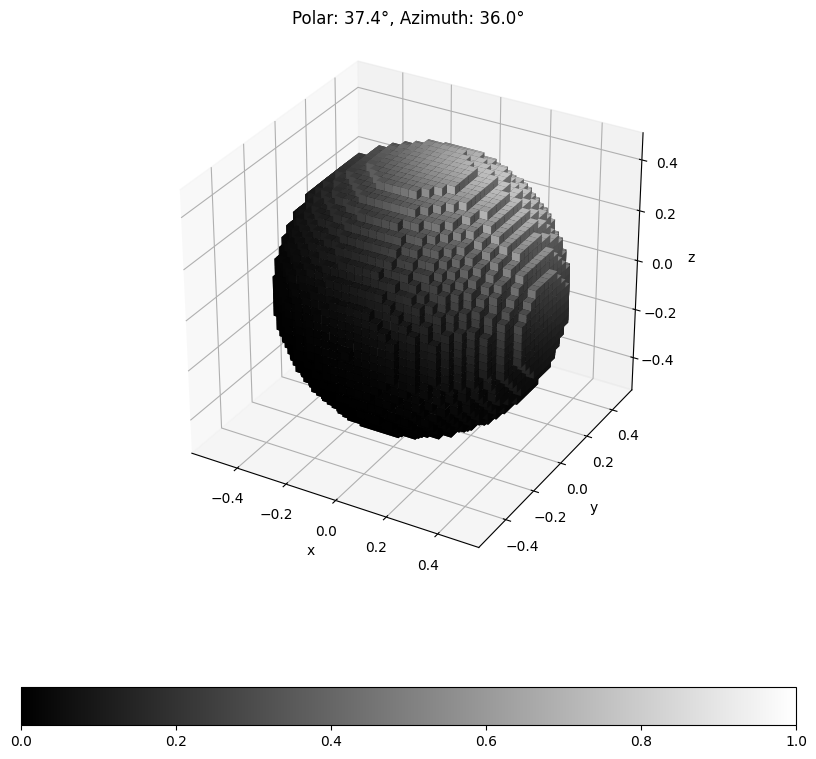

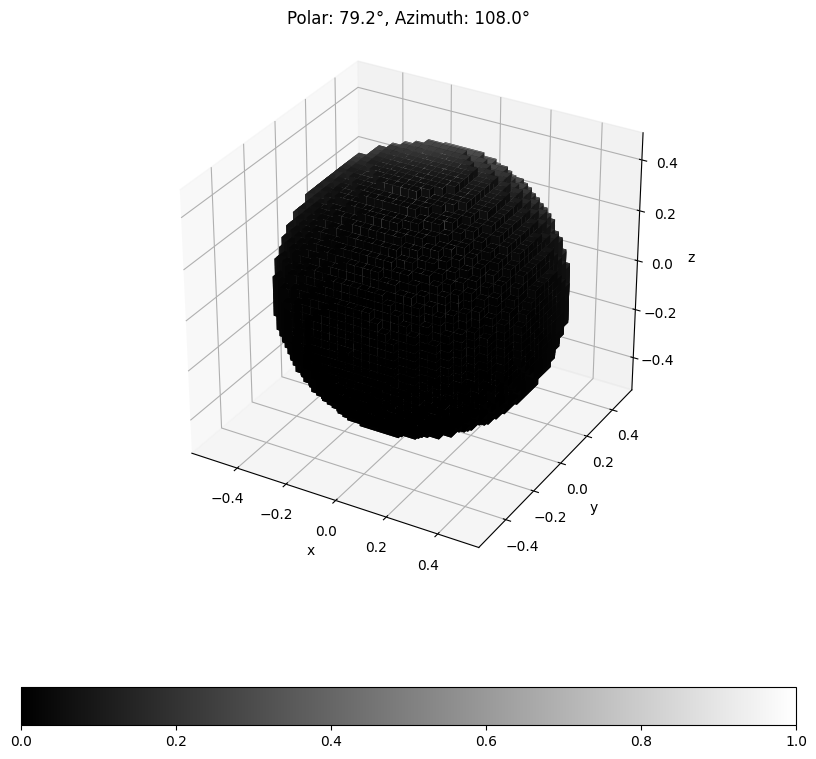

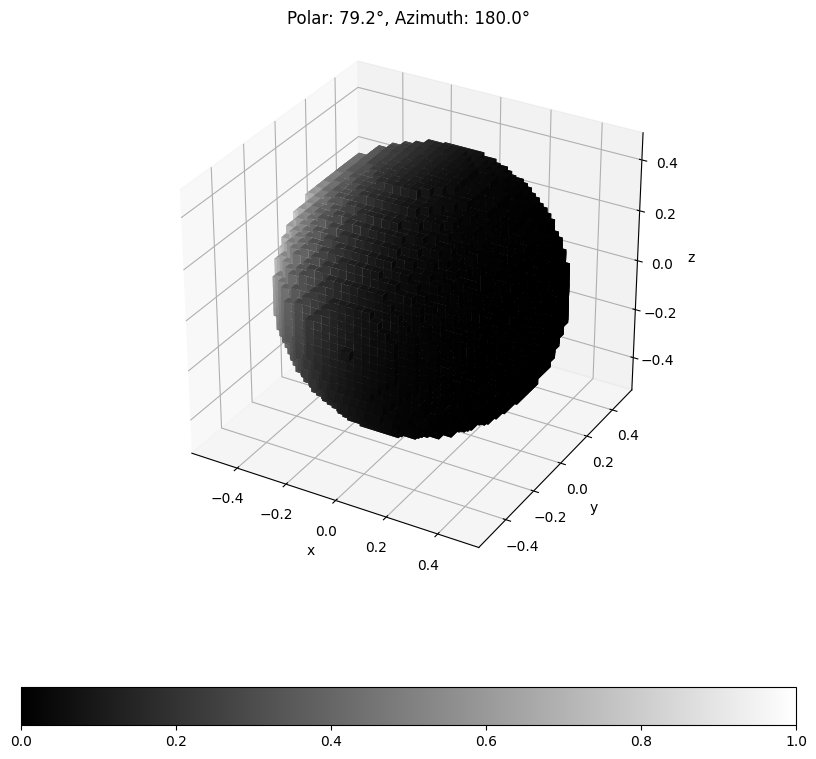

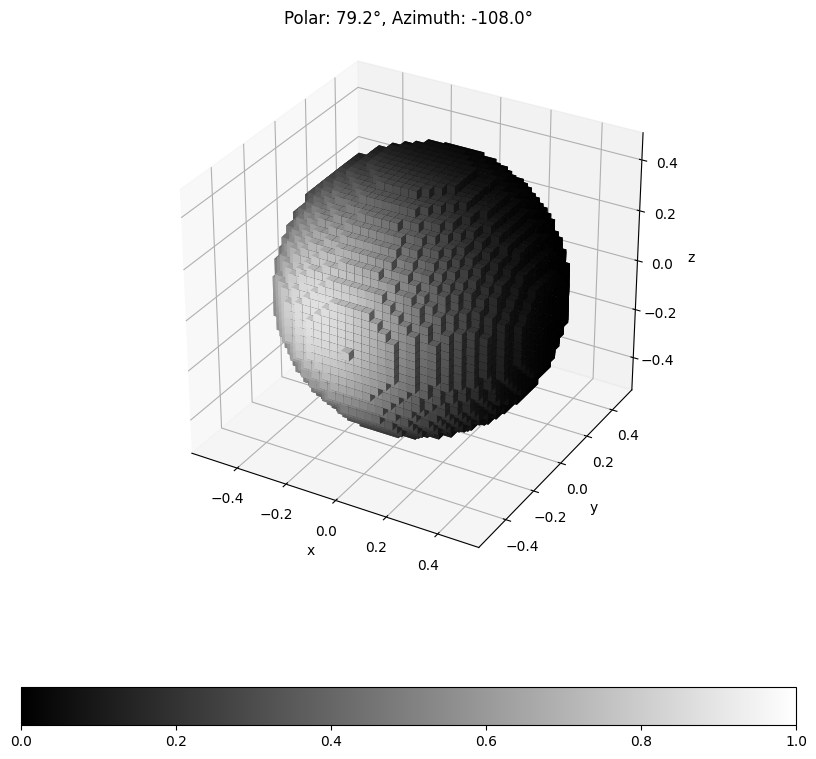

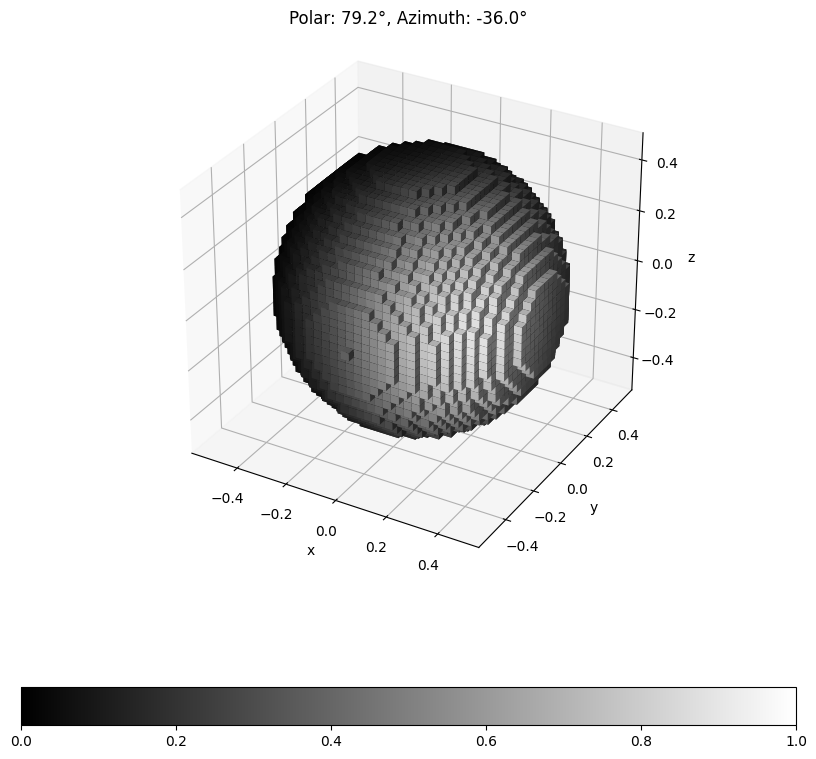

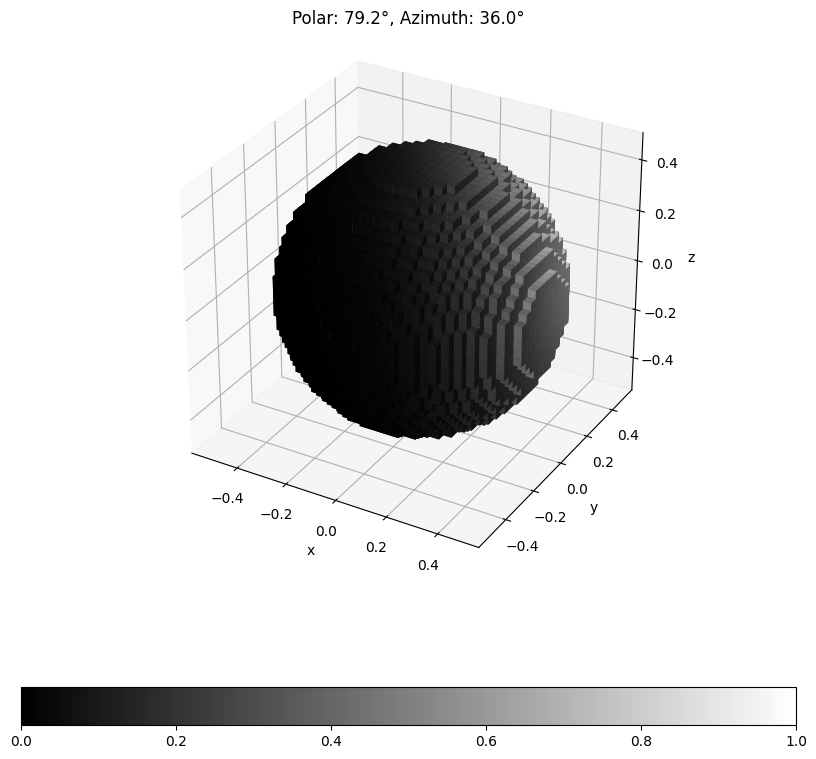

In [16]:
from collections import namedtuple
from math import acos, sqrt, atan
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import matplotlib as mpl

nx, ny, nz = 32, 32, 32

Ori3D = namedtuple('Ori3D', ['polar', 'azimuth'])
orientations = [Ori3D(polar=atan(3 - sqrt(5)), azimuth=3 * pi / 5),
                Ori3D(polar=atan(3 - sqrt(5)), azimuth=pi),
                Ori3D(polar=atan(3 - sqrt(5)), azimuth=-3 * pi / 5),
                Ori3D(polar=atan(3 - sqrt(5)), azimuth=-pi / 5),
                Ori3D(polar=atan(3 - sqrt(5)), azimuth=pi / 5),
                Ori3D(polar=atan(3 + sqrt(5)), azimuth=3 * pi / 5),
                Ori3D(polar=atan(3 + sqrt(5)), azimuth=pi),
                Ori3D(polar=atan(3 + sqrt(5)), azimuth=-3 * pi / 5),
                Ori3D(polar=atan(3 + sqrt(5)), azimuth=-pi / 5),
                Ori3D(polar=atan(3 + sqrt(5)), azimuth=pi / 5)]

freq, fx, fy, fz = _filter_grids_3d(nx, ny, nx)
sin_polar, cos_polar, sin_azimuth, cos_azimuth = _grid_angles_3d(freq, fx, fy, fz)
theta_sigma = acos(sqrt(5) / 3)  # icosohedron internal angle

# Make voxel edges (unshifted)
fx_c, fy_c, fz_c = np.meshgrid(
    to_edges(_spaced_frequencies(nx)),
    to_edges(_spaced_frequencies(ny)),
    to_edges(_spaced_frequencies(nz)),
    indexing='ij'
)

for ori in orientations:
    fig: plt.Figure
    ax: Axes3D
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    fig.set_size_inches(10, 10)

    angle_filter = _gaussian_angular_filter_3d(ori.polar, ori.azimuth, theta_sigma, sin_polar, cos_polar, sin_azimuth,
                                               cos_azimuth)
    vox = fftshift(angle_filter)
    m = mpl.cm.ScalarMappable(cmap=plt.cm.gray)
    cax = ax.voxels(fx_c, fy_c, fz_c, fftshift(freq) <= 0.5,
                    facecolors=mpl.colormaps['gray']((vox - vox.min()) / (vox.max() - vox.min())))
    ax.set_title(f'Polar: {ori.polar * 180 / pi:.1f}°, Azimuth: {ori.azimuth * 180 / pi:.1f}°')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    m = mpl.cm.ScalarMappable(cmap=plt.cm.gray)
    fig.colorbar(m, ax=ax, orientation='horizontal')
    ax.set_aspect('equal')


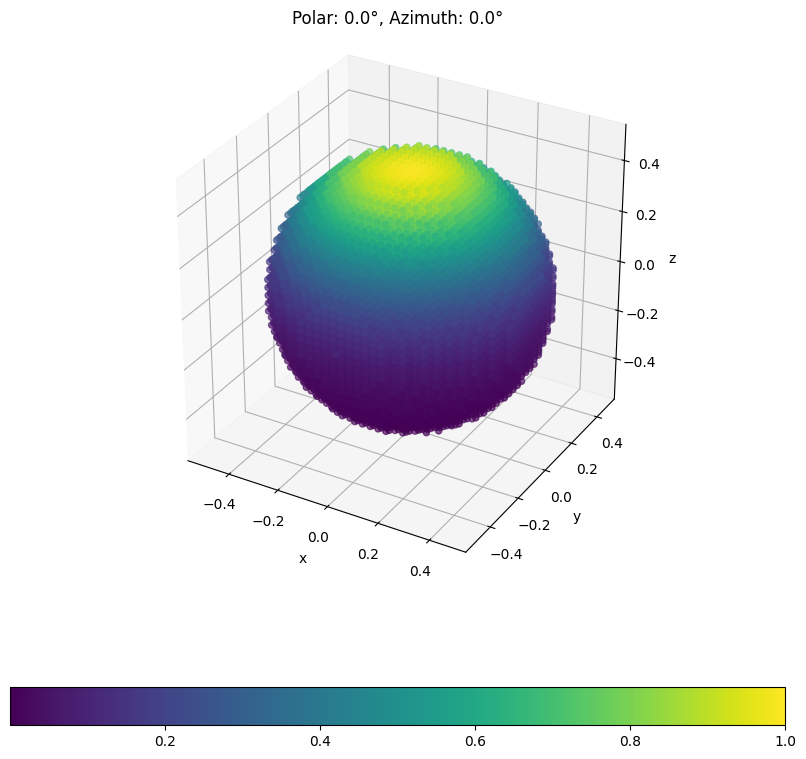

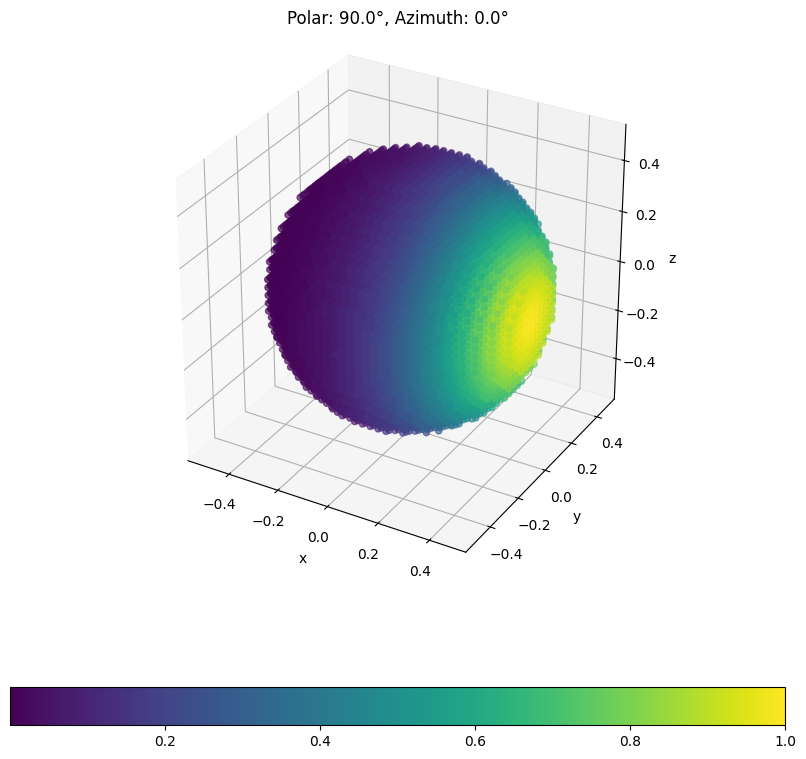

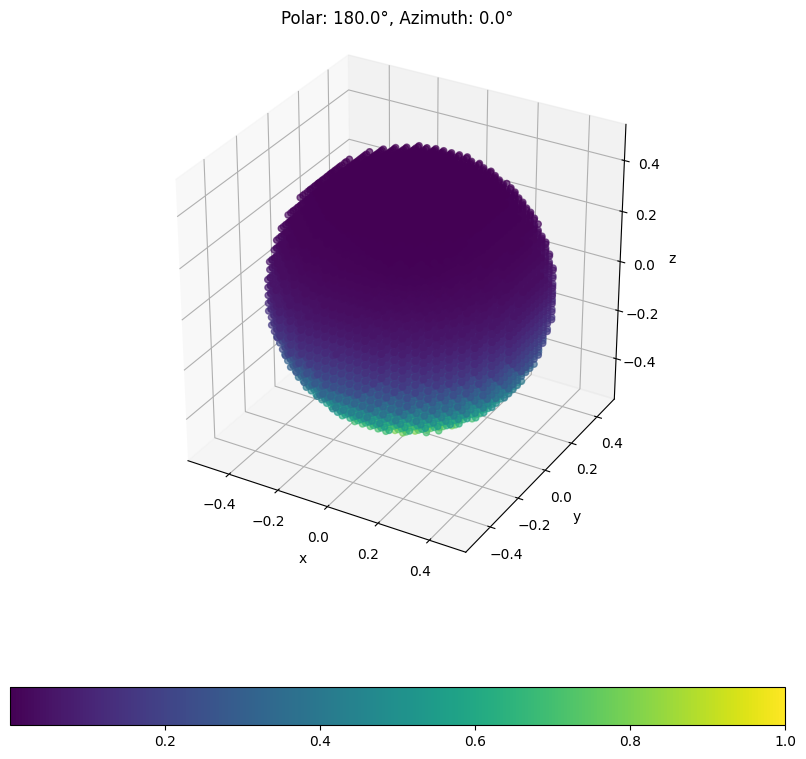

In [17]:

from mpl_toolkits.mplot3d import Axes3D

orientations = [
    Ori3D(polar=0, azimuth=0),
    Ori3D(polar=pi / 2, azimuth=0),
    Ori3D(polar=pi, azimuth=0),
]

for ori in orientations:
    fig: plt.Figure
    ax: Axes3D
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    fig.set_size_inches(10, 10)

    angle_filter = _gaussian_angular_filter_3d(ori.polar, ori.azimuth, theta_sigma, sin_polar, cos_polar, sin_azimuth,
                                               cos_azimuth)
    cax = ax.scatter3D(fx[freq <= 0.5], fy[freq <= 0.5], fz[freq <= 0.5], c=angle_filter[freq <= 0.5])
    ax.set_title(f'Polar: {ori.polar * 180 / pi:.1f}°, Azimuth: {ori.azimuth * 180 / pi:.1f}°')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    fig.colorbar(cax, orientation='horizontal')
    ax.set_aspect('equal')


(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.2767e+04]),
 array([1.97177548, 2.22194579, 2.47211609, 2.7222864 , 2.97245671,
        3.22262701, 3.47279732, 3.72296762, 3.97313793, 4.22330823,
        4.47347854]),
 <BarContainer object of 10 artists>)

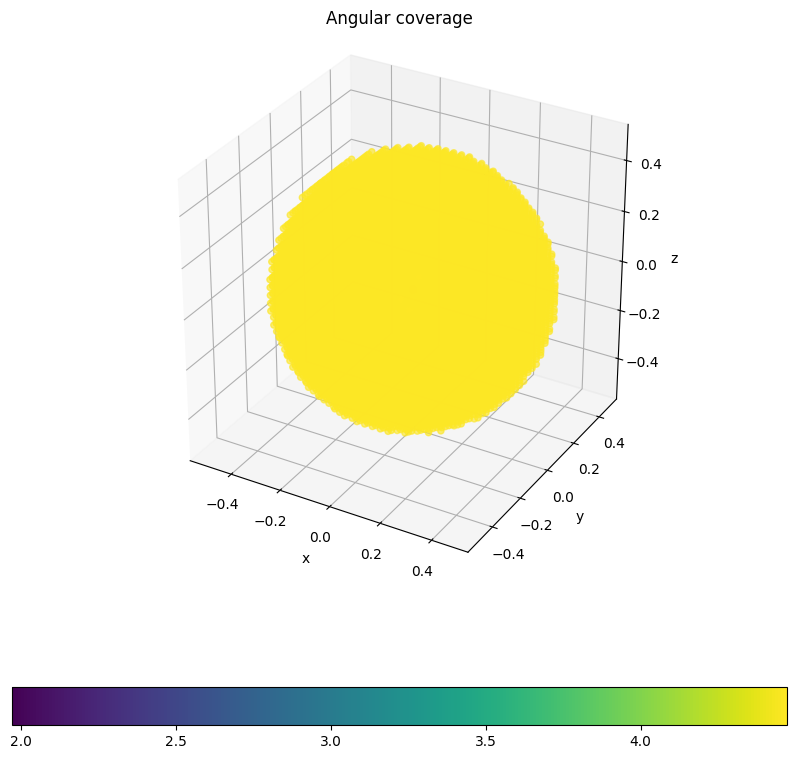

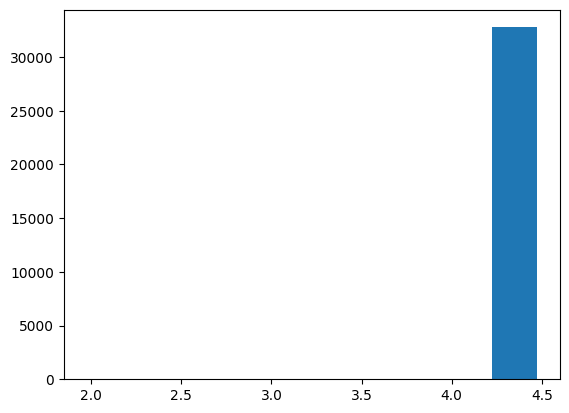

In [36]:
from collections import namedtuple
from math import sqrt, atan
from mpl_toolkits.mplot3d import Axes3D

import numpy as np

theta_sigma = acos(sqrt(5) / 3)  # icosohedron internal angle

Ori3D = namedtuple('Ori3D', ['polar', 'azimuth'])
full_orientations = [
    Ori3D(polar=atan(3 - sqrt(5)), azimuth=3 * pi / 5),
    Ori3D(polar=atan(3 - sqrt(5)), azimuth=pi),
    Ori3D(polar=atan(3 - sqrt(5)), azimuth=-3 * pi / 5),
    Ori3D(polar=atan(3 - sqrt(5)), azimuth=-pi / 5),
    Ori3D(polar=atan(3 - sqrt(5)), azimuth=pi / 5),
    Ori3D(polar=atan(3 + sqrt(5)), azimuth=3 * pi / 5),
    Ori3D(polar=atan(3 + sqrt(5)), azimuth=pi),
    Ori3D(polar=atan(3 + sqrt(5)), azimuth=-3 * pi / 5),
    Ori3D(polar=atan(3 + sqrt(5)), azimuth=-pi / 5),
    Ori3D(polar=atan(3 + sqrt(5)), azimuth=pi / 5),
    Ori3D(polar=pi - atan(3 - sqrt(5)), azimuth=-(2 * pi) / 5),
    Ori3D(polar=pi - atan(3 - sqrt(5)), azimuth=0),
    Ori3D(polar=pi - atan(3 - sqrt(5)), azimuth=(2 * pi) / 5),
    Ori3D(polar=pi - atan(3 - sqrt(5)), azimuth=(4 * pi) / 5),
    Ori3D(polar=pi - atan(3 - sqrt(5)), azimuth=-(4 * pi) / 5),
    Ori3D(polar=pi - atan(3 + sqrt(5)), azimuth=-(2 * pi) / 5),
    Ori3D(polar=pi - atan(3 + sqrt(5)), azimuth=0),
    Ori3D(polar=pi - atan(3 + sqrt(5)), azimuth=(2 * pi) / 5),
    Ori3D(polar=pi - atan(3 + sqrt(5)), azimuth=(4 * pi) / 5),
    Ori3D(polar=pi - atan(3 + sqrt(5)), azimuth=-(4 * pi) / 5)
]

angle_filters = []
for ori in full_orientations:
    angle_filter = _gaussian_angular_filter_3d(ori.polar, ori.azimuth, theta_sigma, sin_polar, cos_polar, sin_azimuth,
                                               cos_azimuth)
    angle_filters.append(angle_filter)
angle_coverage = np.sum(angle_filters, axis=0)

fig: plt.Figure
ax: Axes3D
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
fig.set_size_inches(10, 10)
cax = ax.scatter3D(fx[freq <= 0.5], fy[freq <= 0.5], fz[freq <= 0.5], c=angle_coverage[freq <= 0.5])
ax.set_title(f'Angular coverage')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
fig.colorbar(cax, orientation='horizontal')
ax.set_aspect('equal')

fig, ax = plt.subplots()
ax.hist(angle_coverage.flatten())